# PCOS Binary Classification Model

<img src="cover.png" width="" align="" />

<img src="what_is_pcos.png" width="" align="" />

<img src="table-of-contents.png" width="75%" align="" />

Let's load and explore the dataset.

## Import Libraries

The following are the initial implementations and imports we should have before moving onto the actual model.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import itertools
import math
import statsmodels

from sklearn import set_config
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline 
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import learning_curve, validation_curve, train_test_split, KFold, StratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV, cross_validate, RepeatedStratifiedKFold
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import FunctionTransformer, StandardScaler, RobustScaler, PowerTransformer
from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import loguniform, beta, uniform, zscore

from mlxtend.feature_selection import SequentialFeatureSelector

from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import TomekLinks, RandomUnderSampler
from imblearn.pipeline import Pipeline as IMBPipeline

from itertools import product

from statsmodels.stats.outliers_influence import variance_inflation_factor

from xgboost import XGBClassifier

import missingno as msno

import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

print('setup complete')

setup complete


## Data Loading

First, let's upload the datasets and then we'll take a first glance at its structure and then move onto data preprocessing.

In [2]:
dataset = pd.read_csv('pcos_detection.csv')

Check the column names and explore the type of features, whether they're categorical or numerical.

In [3]:
dataset.head()

,Sl. No,Patient File No.,PCOS (Y/N),Age (yrs),Weight (Kg),Height(Cm),BMI,Blood Group,Pulse rate(bpm),RR (breaths/min),...,Fast food (Y/N),Reg.Exercise(Y/N),BP _Systolic (mmHg),BP _Diastolic (mmHg),Follicle No. (L),Follicle No. (R),Avg. F size (L) (mm),Avg. F size (R) (mm),Endometrium (mm),Unnamed: 44
0,1,1,0,28,44.6,152.0,19.3,15,78,22,...,1.0,0,110,80,3,3,18.0,18.0,8.5,NaN
1,2,2,0,36,65.0,161.5,24.9,15,74,20,...,0.0,0,120,70,3,5,15.0,14.0,3.7,NaN
2,3,3,1,33,68.8,165.0,25.3,11,72,18,...,1.0,0,120,80,13,15,18.0,20.0,10.0,NaN
3,4,4,0,37,65.0,148.0,29.7,13,72,20,...,0.0,0,120,70,2,2,15.0,14.0,7.5,NaN
4,5,5,0,25,52.0,161.0,20.1,11,72,18,...,0.0,0,120,80,3,4,16.0,14.0,7.0,NaN


Now that we have read the dataset, it's the best option to take a look at the structure of the dataset. We can see that there are 45 features in total, which are many considering there is a total of 541 rows, so they will have to be reduced later and cleared up of any unneeded ones.

I am interested in checking the type of data there is in my dataset.

In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 45 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Sl. No                  541 non-null    int64  
 1   Patient File No.        541 non-null    int64  
 2   PCOS (Y/N)              541 non-null    int64  
 3    Age (yrs)              541 non-null    int64  
 4   Weight (Kg)             541 non-null    float64
 5   Height(Cm)              541 non-null    float64
 6   BMI                     541 non-null    float64
 7   Blood Group             541 non-null    int64  
 8   Pulse rate(bpm)         541 non-null    int64  
 9   RR (breaths/min)        541 non-null    int64  
 10  Hb(g/dl)                541 non-null    float64
 11  Cycle(R/I)              541 non-null    int64  
 12  Cycle length(days)      541 non-null    int64  
 13  Marraige Status (Yrs)   540 non-null    float64
 14  Pregnant(Y/N)           541 non-null    in

From this, we can see how almost all columns are entirely integers or floats, while only 3 happen to have some 'object' type. 

As at least two of those three columns, namely 'II beta-HCG(mIU/mL)' and 'AMH(ng/mL)',  should be entirely numerical, I will later be concerned with solving this issue.

I am instead now interested only in ensuring consistent names in columns, as there are many trailing spaces as well as case sensitivity. This will make it easier for me to keep track of the names and will facilitate the overall analysis.

In [5]:
dataset.columns = dataset.columns.str.strip().str.lower().str.replace(' ', '_')

### Data Distribution Analysis

Before we move onto data preprocessing, let's roughty check correlation by visualizing distributions.

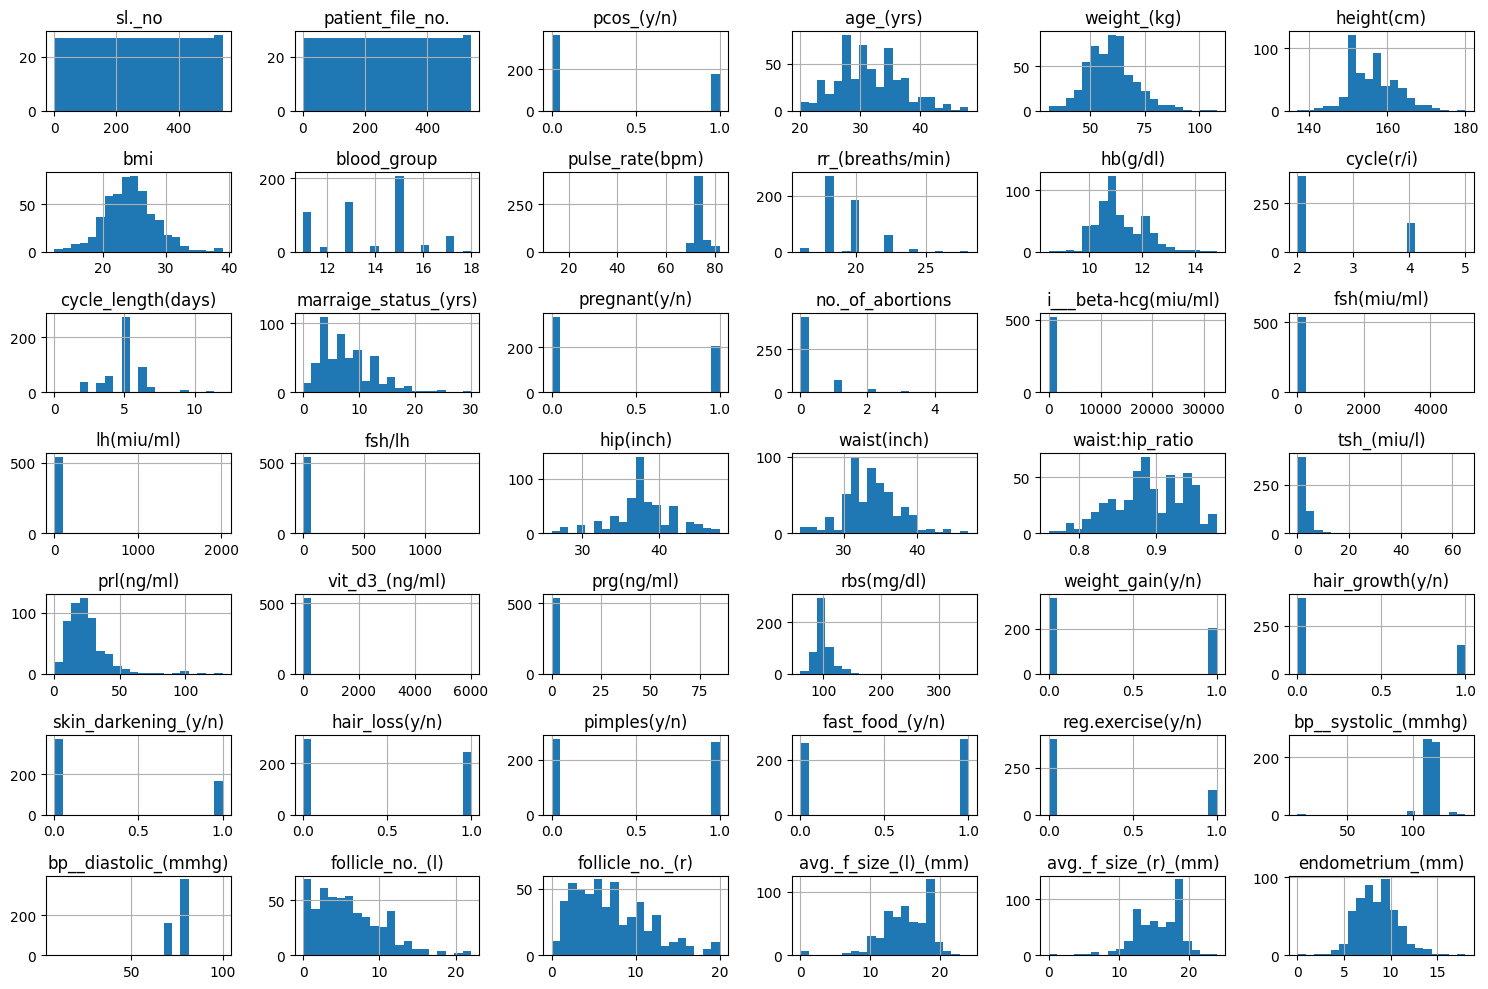

In [6]:
# Visualize distributions of columns
dataset.hist(bins=20, figsize=(15, 10))
plt.tight_layout()
plt.show()

A type of column that we can already see needs to be dropped is the one about the patient number and file, as it's completely irrelevant for what I will want to predict, so whether a person has PCOS or not.

In [7]:
dataset.drop(['patient_file_no.','sl._no'], axis=1, inplace=True)

For some columns we can see that they have very little variance, before we decide whether we should drop them or not, it's better to take a closer look at them.

In [8]:
dataset[['fsh(miu/ml)', 'lh(miu/ml)', 'fsh/lh', 'vit_d3_(ng/ml)', 'prg(ng/ml)', 'i___beta-hcg(miu/ml)']]

,fsh(miu/ml),lh(miu/ml),fsh/lh,vit_d3_(ng/ml),prg(ng/ml),i___beta-hcg(miu/ml)
0,7.95,3.68,2.16,17.1,0.57,1.99
1,6.73,1.09,6.17,61.3,0.97,60.80
2,5.54,0.88,6.30,49.7,0.36,494.08
3,8.06,2.36,3.42,33.4,0.36,1.99
4,3.98,0.90,4.42,43.8,0.38,801.45
...,...,...,...,...,...,...
536,10.06,1.81,5.56,36.6,0.25,1.99
537,5.07,2.84,1.79,23.0,0.25,80.13
538,11.96,2.78,4.30,22.5,0.25,1.99
539,4.40,4.33,1.02,22.4,0.25,292.92


Overall, it can be seen how it's not true that they aren't showing variance, so it's better to keep them for now.

### Data Cleaning

By looking at data, there are 2 columns with problematic values that are not strictly digits or dots, or that have trailing dots. It's necessary to clean said data and make it such that it will be usable later inside our model.

This could already be seen in the exploration of data as they were neither floats or integers strictly.

Define a method to clear said problematic values, called clean_numerical_column, that replaces non-numeric and non-dot characters with an empty strings, and replaces eventual empty strings with NaN, and convert them to float type.

In [9]:
def clean_numerical_column(column):
    return pd.to_numeric(column.replace(r'[^0-9.]', '', regex=True).str.strip('.'), errors='coerce')

# apply the cleaning to affected columns
dataset['ii____beta-hcg(miu/ml)'] = clean_numerical_column(dataset['ii____beta-hcg(miu/ml)'])
dataset['amh(ng/ml)'] = clean_numerical_column(dataset['amh(ng/ml)'])

Let's check that the method worked and that the type has changed by using the dtypes' method:

In [10]:
print(dataset.dtypes['amh(ng/ml)'])
print(dataset.dtypes['ii____beta-hcg(miu/ml)'])

float64
float64


### Missing Data Analysis

Let's first look for any missing data in our dataset:

In [11]:
# check the number of missing values for each column
dataset.isnull().sum(axis=0)

pcos_(y/n)                  0
age_(yrs)                   0
weight_(kg)                 0
height(cm)                  0
bmi                         0
blood_group                 0
pulse_rate(bpm)             0
rr_(breaths/min)            0
hb(g/dl)                    0
cycle(r/i)                  0
cycle_length(days)          0
marraige_status_(yrs)       1
pregnant(y/n)               0
no._of_abortions            0
i___beta-hcg(miu/ml)        0
ii____beta-hcg(miu/ml)      0
fsh(miu/ml)                 0
lh(miu/ml)                  0
fsh/lh                      0
hip(inch)                   0
waist(inch)                 0
waist:hip_ratio             0
tsh_(miu/l)                 0
amh(ng/ml)                  1
prl(ng/ml)                  0
vit_d3_(ng/ml)              0
prg(ng/ml)                  0
rbs(mg/dl)                  0
weight_gain(y/n)            0
hair_growth(y/n)            0
skin_darkening_(y/n)        0
hair_loss(y/n)              0
pimples(y/n)                0
fast_food_

Let's visualize missing data using the missingno library.

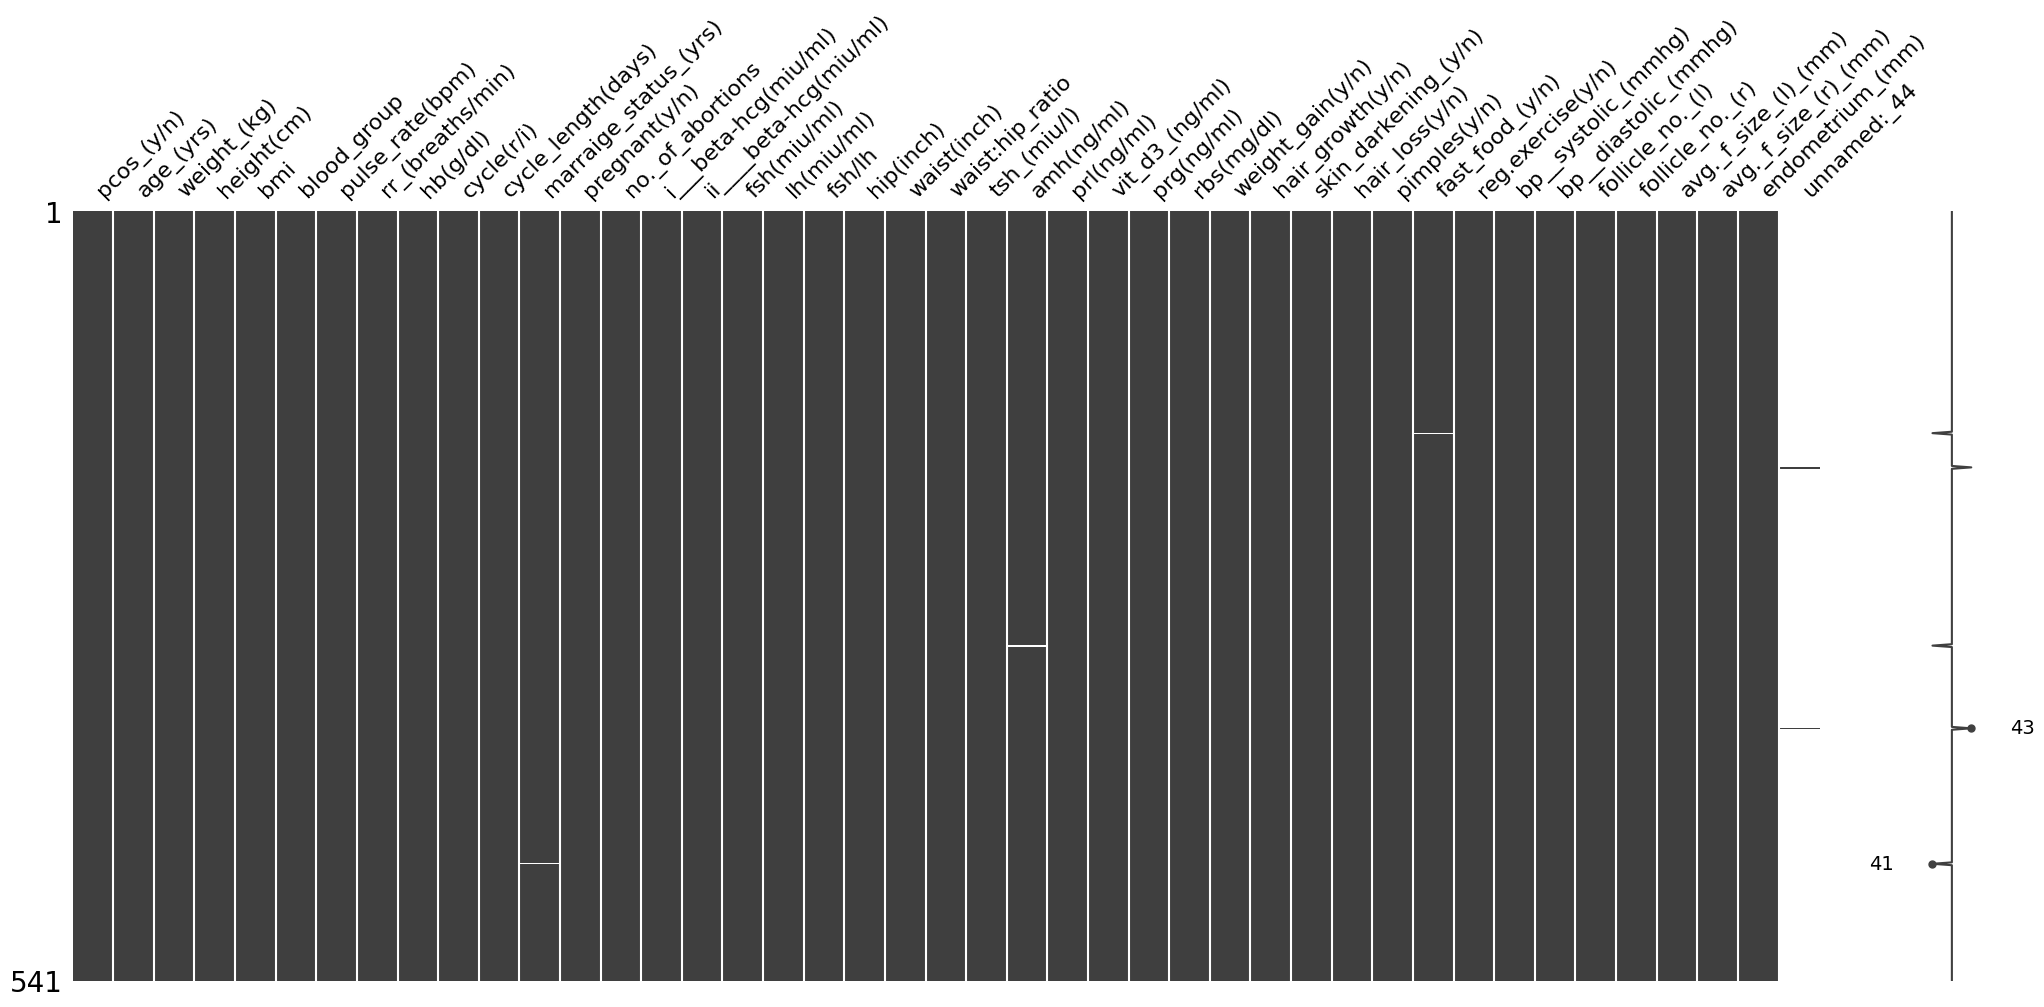

In [12]:
msno.matrix(dataset)
plt.show()

There are basically only 3 missing values in the whole dataset, whereas the column 'unnamed:_44' is completely empty except for 2 values, making it basically useless, also considering the fact its name is also not really expressing nor evoking anything related to PCOS.

In [13]:
dataset.drop('unnamed:_44', axis=1, inplace=True)

In the instructions attached to the dataset, we can see how Beta HCG measures are repeated twice just in case, but they are basically the same measure. It's enough to drop the second trial and keep the first one only.

In [14]:
dataset.drop('ii____beta-hcg(miu/ml)', axis=1, inplace=True)

After dropping said column, it's necessary to add missing data using the following method, in order to make the model more reliable even for data that isn't complete.

In [15]:
def add_missing(col, amount):
    X = col.copy()
    size = amount if amount >= 1 else int(len(X) * amount)
    indexes = np.random.choice(len(X), size, replace = False )
    X[indexes] = np.nan
    return X

I now use the method 'add_missing' in order to do what I said above. I choose to apply the method onto a specific set of 5 columns.

Here we choose a subset of strictly numerical and yes/no columns onto which missing values will be added.

In [16]:
numerical_columns_reduced = ['age_(yrs)', 'bmi', 'endometrium_(mm)']
yesno_columns_reduced = ['weight_gain(y/n)', 'pregnant(y/n)', 'skin_darkening_(y/n)']

# 4% missing values
missing_percentage = 0.04

# Apply missing values to selected columns
for column in numerical_columns_reduced + yesno_columns_reduced:
    dataset[column] = add_missing(dataset[column], missing_percentage)

print("Missing values after adding missing data:")
print(dataset.isnull().sum())

Missing values after adding missing data:
pcos_(y/n)                0
age_(yrs)                21
weight_(kg)               0
height(cm)                0
bmi                      21
blood_group               0
pulse_rate(bpm)           0
rr_(breaths/min)          0
hb(g/dl)                  0
cycle(r/i)                0
cycle_length(days)        0
marraige_status_(yrs)     1
pregnant(y/n)            21
no._of_abortions          0
i___beta-hcg(miu/ml)      0
fsh(miu/ml)               0
lh(miu/ml)                0
fsh/lh                    0
hip(inch)                 0
waist(inch)               0
waist:hip_ratio           0
tsh_(miu/l)               0
amh(ng/ml)                1
prl(ng/ml)                0
vit_d3_(ng/ml)            0
prg(ng/ml)                0
rbs(mg/dl)                0
weight_gain(y/n)         21
hair_growth(y/n)          0
skin_darkening_(y/n)     21
hair_loss(y/n)            0
pimples(y/n)              0
fast_food_(y/n)           1
reg.exercise(y/n)         0
bp__sy

Let's visualize our dataset as we did before, we will now see how the presence of missing values is higher.

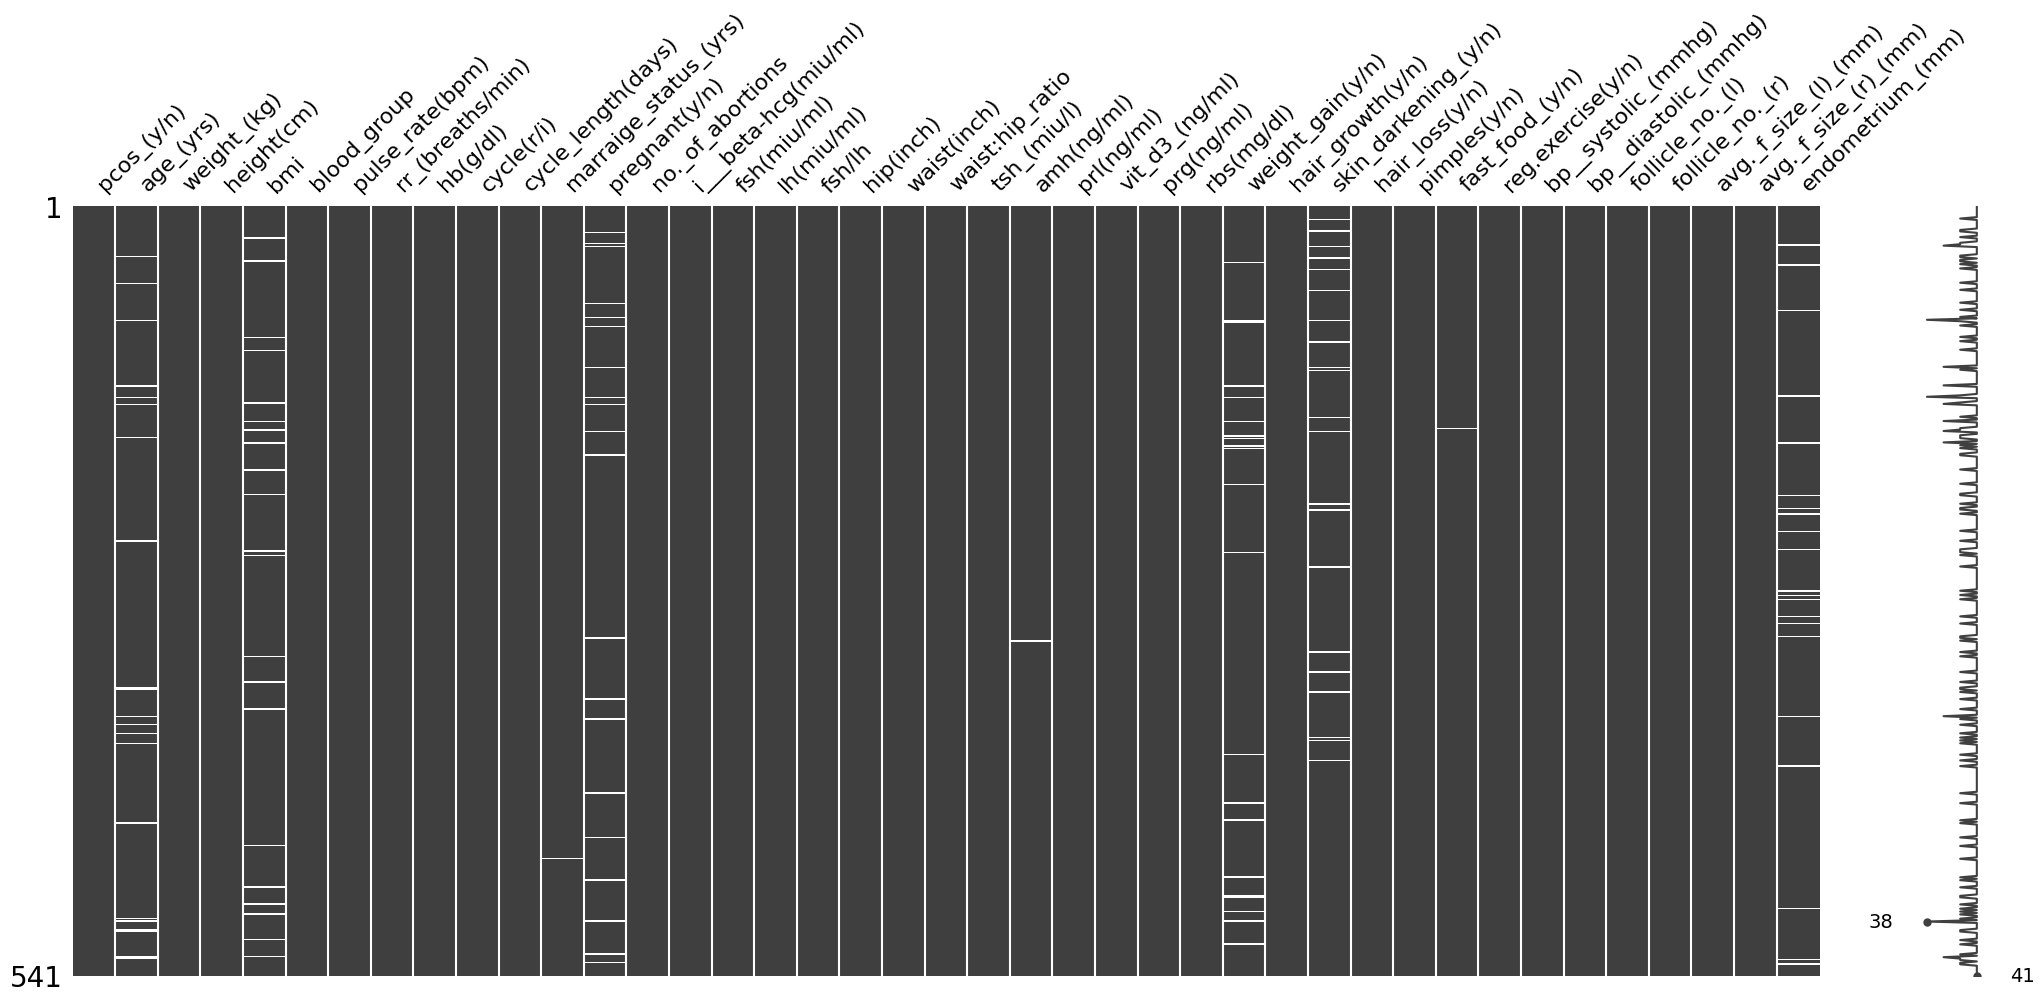

In [17]:
# Visualize new missing data
msno.matrix(dataset)
plt.show()

Now, we can move to the creation of a preprocessing pipeline to handle missing data.

### Data Distribution

Before the pipeline is defined, let's decide either for the Standard Scaler or the Min-Max Scaler by first checking if there are any outliers in the numerical categories, i.e. those that aren't either YES (1) or NO (0). To do so, we can first do that by using the 'describe()' method.

In [18]:
numerical = [column for column in dataset.columns if '(y/n)' not in column]
dataset[numerical].describe()

,age_(yrs),weight_(kg),height(cm),bmi,blood_group,pulse_rate(bpm),rr_(breaths/min),hb(g/dl),cycle(r/i),cycle_length(days),...,vit_d3_(ng/ml),prg(ng/ml),rbs(mg/dl),bp__systolic_(mmhg),bp__diastolic_(mmhg),follicle_no._(l),follicle_no._(r),avg._f_size_(l)_(mm),avg._f_size_(r)_(mm),endometrium_(mm)
count,520.000000,541.000000,541.000000,520.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.00000,...,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,520.000000
mean,31.350000,59.637153,156.484835,24.259231,13.802218,73.247689,19.243993,11.160037,2.560074,4.94085,...,49.915874,0.610945,99.835860,114.661738,76.927911,6.129390,6.641405,15.018115,15.451701,8.466096
std,5.380028,11.028287,6.033545,4.092113,1.840812,4.430285,1.688629,0.866904,0.901950,1.49202,...,346.206599,3.808853,18.559298,7.384556,5.574112,4.229294,4.436889,3.566839,3.318848,2.156073
min,20.000000,31.000000,137.000000,12.400000,11.000000,13.000000,16.000000,8.500000,2.000000,0.00000,...,0.000000,0.047000,60.000000,12.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,27.000000,52.000000,152.000000,21.600000,13.000000,72.000000,18.000000,10.500000,2.000000,4.00000,...,20.800000,0.250000,92.000000,110.000000,70.000000,3.000000,3.000000,13.000000,13.000000,7.000000
50%,31.000000,59.000000,156.000000,24.100000,14.000000,72.000000,18.000000,11.000000,2.000000,5.00000,...,25.900000,0.320000,100.000000,110.000000,80.000000,5.000000,6.000000,15.000000,16.000000,8.500000
75%,35.000000,65.000000,160.000000,26.600000,15.000000,74.000000,20.000000,11.700000,4.000000,5.00000,...,34.500000,0.450000,107.000000,120.000000,80.000000,9.000000,10.000000,18.000000,18.000000,9.800000
max,48.000000,108.000000,180.000000,38.900000,18.000000,82.000000,28.000000,14.800000,5.000000,12.00000,...,6014.660000,85.000000,350.000000,140.000000,100.000000,22.000000,20.000000,24.000000,24.000000,18.000000


We can already see visually that there is a number of outliers. For some values, the mean for example is much smaller than the max value, so it's necessary to delve deeper. As this is the case for many of these kinds of columns, we have to choose an appropriate Scaler.

In order to further verify the presence of outlier, a boxplot will be the best at highlighting their presence. 

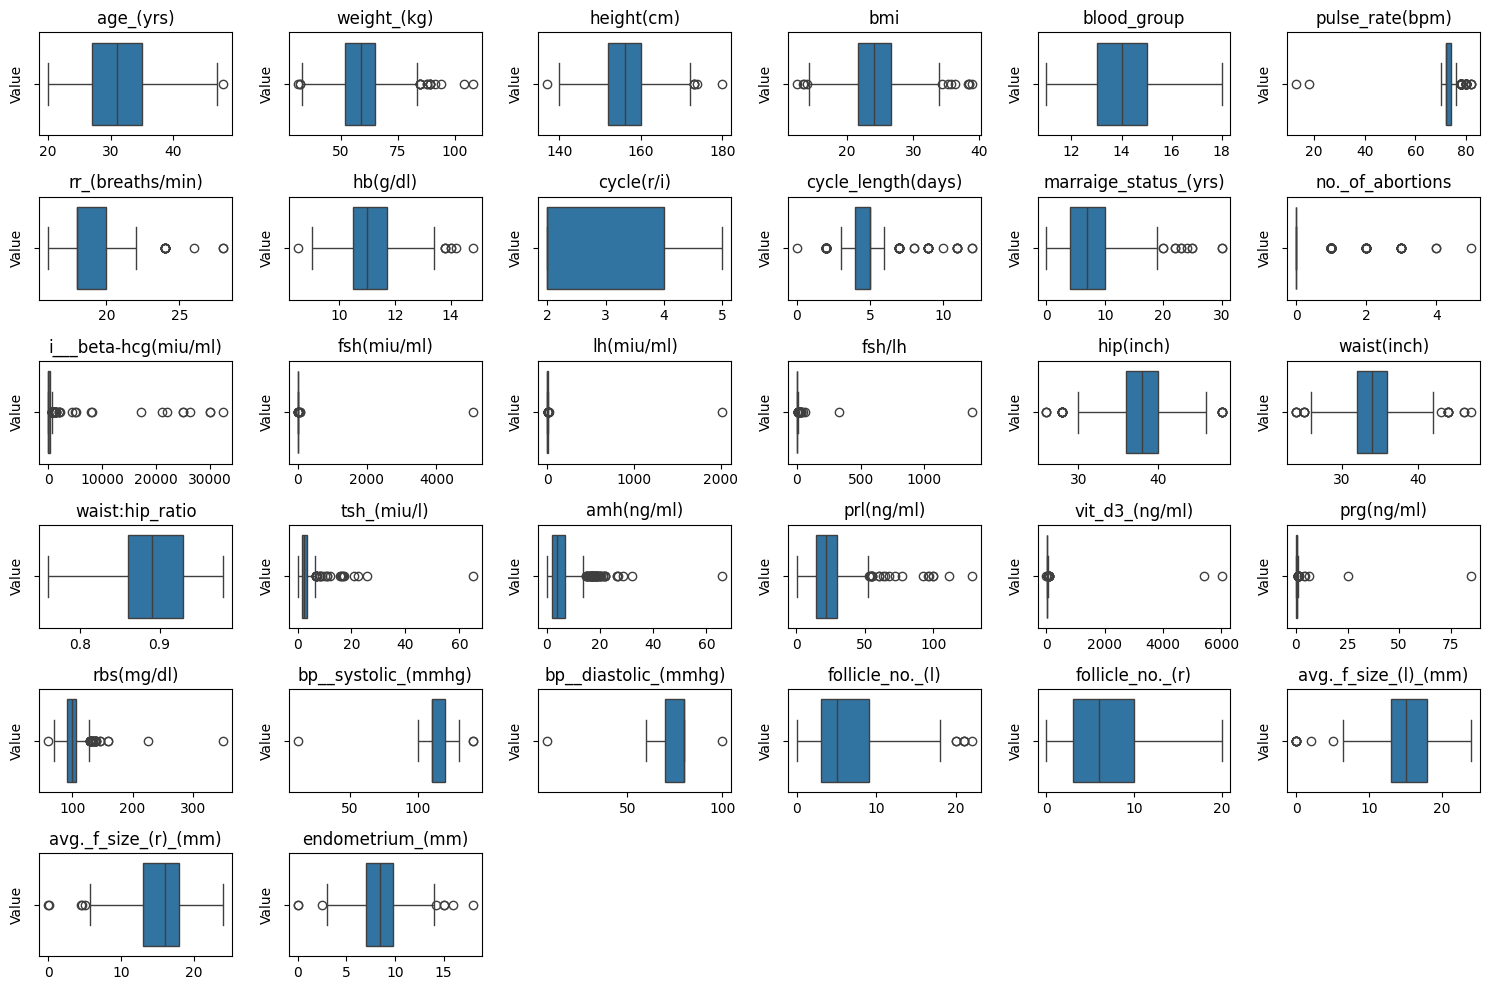

In [19]:
num_cols = len(numerical)
grid_size = math.ceil(math.sqrt(num_cols))  # Create a square-like grid
fig, axes = plt.subplots(grid_size, grid_size, figsize=(15, 10))

axes = axes.flatten()
for ax in axes[num_cols:]:
    ax.remove()

# Plot boxplots
for i, column in enumerate(numerical):
    sns.boxplot(data=dataset, x=column, ax=axes[i])
    axes[i].set_title(f'{column}')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Value')

plt.tight_layout()
plt.show()

As there are many mild outliers, the choice of the imputer will lean towards the StandardScaler, as using a MinMaxScaler would produce an unfeasible result, as it is really sensible to the presence of outliers.

### Data Correlation Analysis

Let's examine possible strong correlations between data and then move onto a deeper analysis. This will help us in later determining which values influence the most whether a woman has PCOS or not.

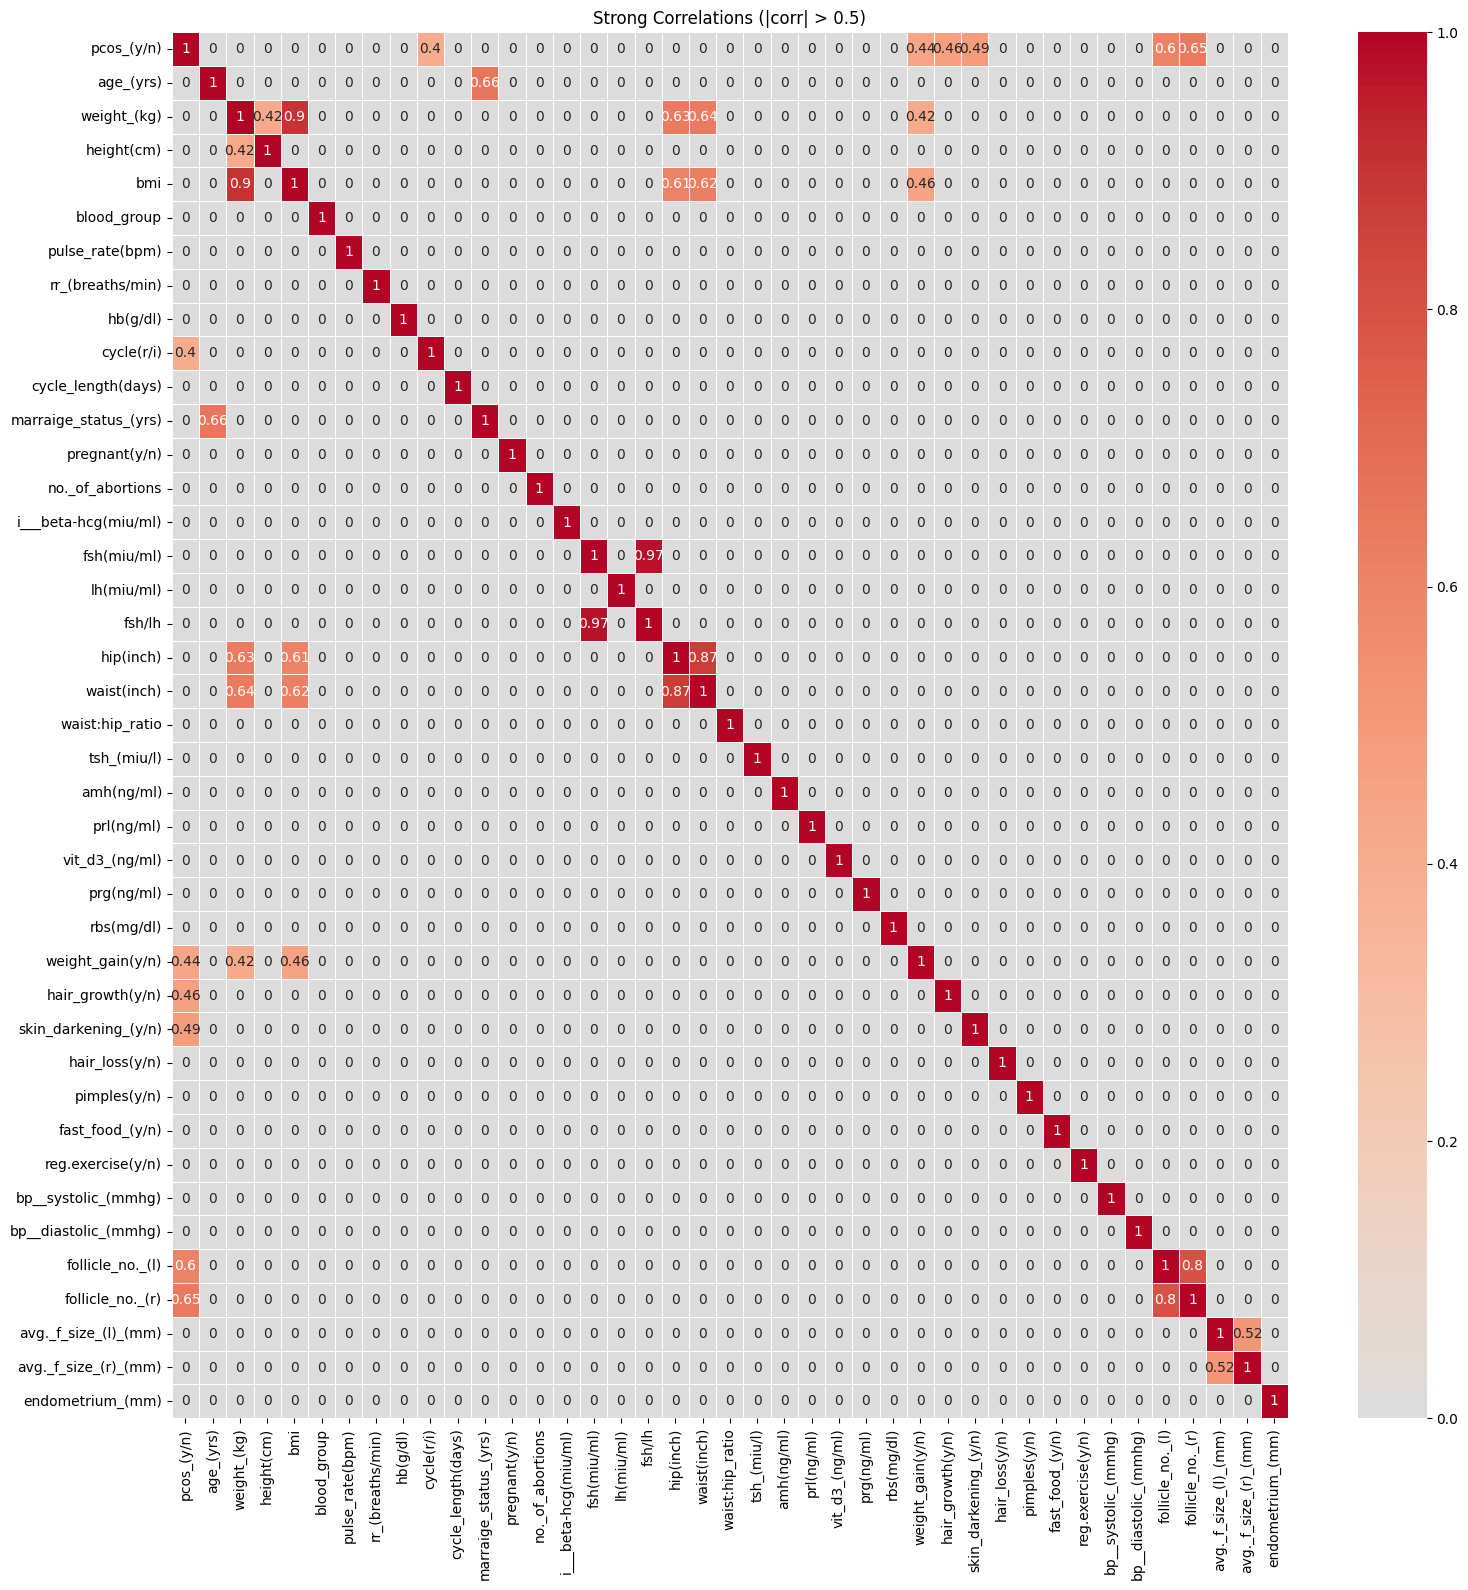

In [20]:
correlation_matrix = dataset.corr()

# strongly correlated features (|corr| > 0.4)
threshold = 0.4 
strong_corr = correlation_matrix[(correlation_matrix > threshold) | (correlation_matrix < -threshold)]
strong_corr.fillna(0, inplace=True)  # Replace NaNs with 0

# heatmap plotting
plt.figure(figsize=(18, 18))
sns.heatmap(strong_corr, annot=True, cmap='coolwarm', center=0, linewidths=0.5)
plt.title('Strong Correlations (|corr| > 0.5)')
plt.show()


We find there is a very strong correlation between:

1. BMI, height, weight gain and weight: of course this is because BMI is calculated using weight and height.

It is also interesting to observe that, in cases without PCOS, the BMI stays the same, while for PCOS we can see an increase over the years.

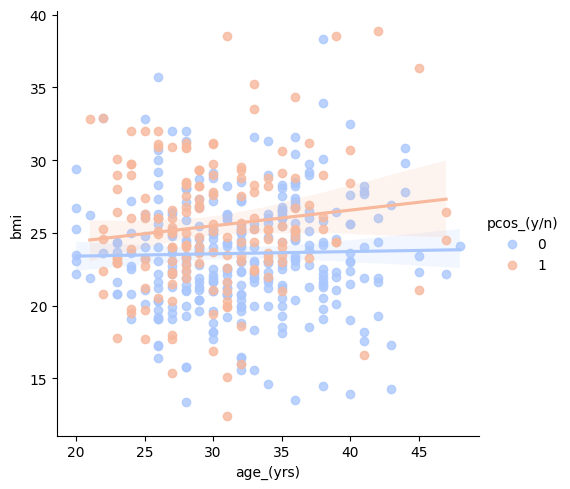

In [21]:
fig= sns.lmplot(data =dataset,x="age_(yrs)",y="bmi", hue="pcos_(y/n)", palette='coolwarm' )
plt.show(fig)

2. Waist and hip measurements: this comes from human proportions, so it's of course comprehensible how they might be very related.

3. FSH and LH measurements: one is the ratio of the other.

4. Follicle numbers and average sizes on the left and right side.

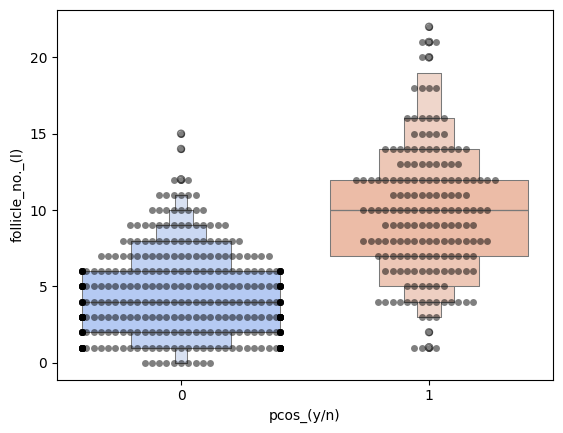

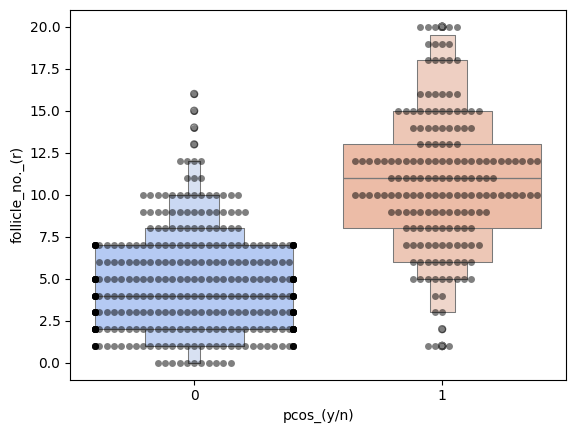

In [22]:
features = ["follicle_no._(l)","follicle_no._(r)"]
for i in features:
    sns.swarmplot(x=dataset["pcos_(y/n)"], y=dataset[i], color="black", alpha=0.5 )
    sns.boxenplot(x=dataset["pcos_(y/n)"], y=dataset[i], palette='coolwarm')
    plt.show()

Both in the right and left follicle we can see how individuals with PCOS have a higher rate. The higher presence of follicles is a common predictor for a diagnosis, but the distribution seems pretty similar for left and right follicles.

Since we are still not sure whether dropping one of them might save us some redundancy or might reduce predictive power, it's better to further analyse those specific features in relation with the target variable 'pcos (y/n)'.

To do so, we exploit the Variance Inflation Factor (VIF), that measures how much the variance of a feature is inflated due to collinearity. If the VIF is very high, it might be best to just drop the feature or combine it with others. It's important to note that VIF isn't considering the correlation with the target variable, but how a variable is related with all other independent variables.

The VIF is built by considering one variable at a time and put it as the target.

In [23]:
cleaned_dataset = dataset[numerical].replace([np.inf, -np.inf], np.nan).dropna()

# Calculate VIF for numerical features
vif_data = pd.DataFrame()
vif_data["feature"] = numerical
vif_data["VIF"] = [variance_inflation_factor(cleaned_dataset.values, i)
                   for i in range(cleaned_dataset.shape[1])]
print(vif_data)

                  feature           VIF
0               age_(yrs)     67.902320
1             weight_(kg)   3481.371546
2              height(cm)  13920.206811
3                     bmi   3471.172063
4             blood_group     60.306121
5         pulse_rate(bpm)    289.438174
6        rr_(breaths/min)    153.568980
7                hb(g/dl)    178.634299
8              cycle(r/i)     11.952451
9      cycle_length(days)     13.667674
10  marraige_status_(yrs)      6.795198
11       no._of_abortions      1.370964
12   i___beta-hcg(miu/ml)      1.118774
13            fsh(miu/ml)     19.939672
14             lh(miu/ml)      1.031504
15                 fsh/lh     20.067201
16              hip(inch)  13621.571799
17            waist(inch)  13512.468420
18        waist:hip_ratio  13989.826000
19            tsh_(miu/l)      1.690257
20             amh(ng/ml)      2.234321
21             prl(ng/ml)      3.883188
22         vit_d3_(ng/ml)      1.057275
23             prg(ng/ml)      1.169489


BMI, weight, height, hip, waist and waist:hip_ratio have all really high VIF values. In this case, t's best to only keep BMI and waist:hip ratio, because they both encapsulate the other features inside their own definition.

In [24]:
dataset.drop(['weight_(kg)', 'height(cm)', 'hip(inch)', 'waist(inch)'], axis=1, inplace=True)

For fsh and lh values, we do the same, as we are already provided with the value of their ratio.

In [25]:
dataset.drop(['fsh(miu/ml)', 'lh(miu/ml)'], axis=1, inplace=True)

Age and marriage years are also highly correlated and have a high VIF, as seen already from the heatmap. It would be better to only keep 'age'.

In [26]:
dataset.drop(['marraige_status_(yrs)'], axis=1, inplace=True)

For other high VIF measures:

<img src="medium_vif.png" width="" align="" />

Overall we will:

1. Drop pulse rate (a higher rate is present if the person is obese, but it's not because of PCOS), breaths per min (same thing), blood group and whether the cycle starts from the right or left ovary, because they are irrelevant and unrelated with PCOS diagnosis.

In [27]:
dataset.drop(['pulse_rate(bpm)', 'rr_(breaths/min)', 'blood_group', 'cycle(r/i)'], axis=1, inplace=True)

2. Combine together systolic and diastolic rates into a single mean blood pressure, as it's an indicator of overall health but may cause redundancy if we keep both, it's better to have just a single metric, the mean arterial pressure. We will do this through a customized transformer inside the first pipeline.

4. Combine together left and right follicle numbers into a single metric indicating the total number of follicles and do the same for the average size of the left and right follicle.

5. Keep the rest.

In [28]:
dataset

,pcos_(y/n),age_(yrs),bmi,hb(g/dl),cycle_length(days),pregnant(y/n),no._of_abortions,i___beta-hcg(miu/ml),fsh/lh,waist:hip_ratio,...,pimples(y/n),fast_food_(y/n),reg.exercise(y/n),bp__systolic_(mmhg),bp__diastolic_(mmhg),follicle_no._(l),follicle_no._(r),avg._f_size_(l)_(mm),avg._f_size_(r)_(mm),endometrium_(mm)
0,0,28.0,19.3,10.48,5,0.0,0,1.99,2.16,0.83,...,0,1.0,0,110,80,3,3,18.0,18.0,8.5
1,0,36.0,24.9,11.70,5,1.0,0,60.80,6.17,0.84,...,0,0.0,0,120,70,3,5,15.0,14.0,3.7
2,1,33.0,25.3,11.80,5,1.0,0,494.08,6.30,0.90,...,1,1.0,0,120,80,13,15,18.0,20.0,10.0
3,0,37.0,29.7,12.00,5,0.0,0,1.99,3.42,0.86,...,0,0.0,0,120,70,2,2,15.0,14.0,7.5
4,0,25.0,20.1,10.00,5,1.0,0,801.45,4.42,0.81,...,0,0.0,0,120,80,3,4,16.0,14.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
536,0,35.0,18.5,11.00,5,0.0,1,1.99,5.56,0.93,...,0,0.0,0,110,70,1,0,17.5,10.0,6.7
537,0,30.0,25.3,10.80,5,1.0,1,80.13,1.79,0.94,...,0,0.0,0,110,70,9,7,19.0,18.0,8.2
538,0,36.0,23.4,10.80,6,0.0,0,1.99,4.30,0.93,...,0,0.0,0,110,80,1,0,18.0,9.0,7.3
539,0,27.0,22.2,12.00,2,0.0,0,292.92,1.02,0.93,...,1,0.0,0,110,70,7,6,18.0,16.0,11.5


### Further reasoning about remaining data

There are some data which may still be irrelevant in PCOS diagnosis. Some of them include:

1. Number of abortions: there’s no strong evidence directly linking abortion history with PCOS diagnosis.  It is more of a downstream effect but not the main reason for a diagnosis as there are many other causes.

2. Fast food consumption: while lifestyle factors such as diet may influence the severity of PCOS symptoms (e.g., insulin resistance), this feature is likely to be too vague. Instead of a binary indicator for fast food consumption, more specific dietary features (e.g., carbohidrate intake, sugar consumption) or actually indicating how many meals a week are fast food, would be more relevant for analysis.

3. Regularity of exercise: Exercise habits are important for managing PCOS but are not directly related to its diagnosis.

4. Pimples and hair growth: these binary symptoms do not add much predictive value to the model as acne and hirsutism (excessive hair growth) are common symptoms of PCOS, but they are secondary symptoms rather than diagnostic criteria, and they are also very common in women without the condition.

In [29]:
dataset.drop(['no._of_abortions', 'fast_food_(y/n)', 'reg.exercise(y/n)', 'pimples(y/n)', 'hair_growth(y/n)'], axis=1, inplace=True)

## Train and test sets

It's time to define the target value I want to predict with the model and the feature variables.

In [30]:
X = dataset.drop('pcos_(y/n)', axis=1)  # Features
y = dataset['pcos_(y/n)']  # Target variable

Now that I've defined X and y, it's time to split data into training and test sets.

In [31]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=0, shuffle=True)

### Pipeline

Let's define our first data transformation Pipeline. As I've chosen which columns have missing values, and I've chosen them in order to either be numerical or binary (y/n), it's enough to define a very simple Pipeline, like the following one.

<img src="preprocessing_pipeline.png" width="" align="" />

The yesno_columns don't need to be either scaled or imputed.

### Creating Custom Transformers

For the systolic and diastolic measures, it's better, in order to reduce redundancy, to introduce a customized transformer that combines them together using the MAP (mean arterial pressure), which is calculated by:

$$$

MAP = {1 \over 3} \times systolic + {2 \over 3} \times diastolic

$$$

Define a customized transformer to handle the two columns, which in this case are to be merged into a single MAP column through the use of the above equation.

In [32]:
class MAPTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, systolic_col, diastolic_col):
        self.systolic_col = systolic_col
        self.diastolic_col = diastolic_col

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X['mean_arterial_pressure'] = (1/3 * X[self.systolic_col] + 2/3 * X[self.diastolic_col])
        return X[['mean_arterial_pressure']]  # Return only the new column
    
    def get_feature_names_out(self, input_features=None):
        return ['mean_arterial_pressure']

It's better to define custom transformers to handle follicle average sizes and numbers in the left and right side, in order to avoid redundacy and just have a single metric for both.

In [33]:
class FollicleNumberTransformer(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Ensure the column names are aligned
        X_copy = X.copy()
        X_copy['total_follicle_number'] = X_copy['follicle_no._(l)'] + X_copy['follicle_no._(r)']
        return X_copy[['total_follicle_number']]  # Return only the new column
    
    def get_feature_names_out(self, input_features=None):
        return ['total_follicle_number']

class AverageSizeTransformer(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Calculate average follicle size (mean of left and right)
        X_copy = X.copy()
        X_copy['average_follicle_size'] = X_copy[['avg._f_size_(l)_(mm)', 'avg._f_size_(r)_(mm)']].mean(axis=1)
        return X_copy[['average_follicle_size']]  # Return only the new column
    
    def get_feature_names_out(self, input_features=None):
        return ['average_follicle_size']

Once we have defined the custom transformers, the columns are divided into multiple lists, each containing a specific set which will be handled in different ways.

In [34]:
# columns to be dealt with using another transformer
other_columns = [
    'bp__systolic_(mmhg)', 'bp__diastolic_(mmhg)',
    'follicle_no._(l)', 'follicle_no._(r)', 
    'avg._f_size_(l)_(mm)', 'avg._f_size_(r)_(mm)'
]

# columns that are skewed (lean towards one side), that will need more tailored transformations
skewed_columns = [
    'prl(ng/ml)', 'vit_d3_(ng/ml)', 'prg(ng/ml)', 
    'fsh/lh', 'i___beta-hcg(miu/ml)', 'amh(ng/ml)', 'tsh_(miu/l)'
]

# columns that are left and that aren't yes/no
numerical_columns = [
    col for col in dataset.columns 
    if '(y/n)' not in col 
    and col not in numerical_columns_reduced + other_columns + skewed_columns
]

It's time to define the pipelines for transformation and imputation of different sets of values.

In [35]:
# Define the numerical transformer
numerical_transformer_reduced = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Define the categorical transformer
yesno_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))
])

skewness_transformer = Pipeline(steps=[
    ('scaler', PowerTransformer(method='yeo-johnson')),
    ('imputer', SimpleImputer(strategy='mean')) # for the amh that has 1 missing value
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_columns),
        ('num_red', numerical_transformer_reduced, numerical_columns_reduced),
        ('yn', yesno_transformer, yesno_columns_reduced),
        ('skewed', skewness_transformer, skewed_columns),
        ('mp', MAPTransformer(systolic_col='bp__systolic_(mmhg)', diastolic_col='bp__diastolic_(mmhg)'), ['bp__systolic_(mmhg)', 'bp__diastolic_(mmhg)']),
        ('follicle_number', FollicleNumberTransformer(), ['follicle_no._(l)', 'follicle_no._(r)']),
        ('average_size', AverageSizeTransformer(), ['avg._f_size_(l)_(mm)', 'avg._f_size_(r)_(mm)'])
    ],
    remainder='passthrough'
)

In order to verify the efficiency of the transformation, it's useful to visualize the effect of the scaling on the values from the dataset.

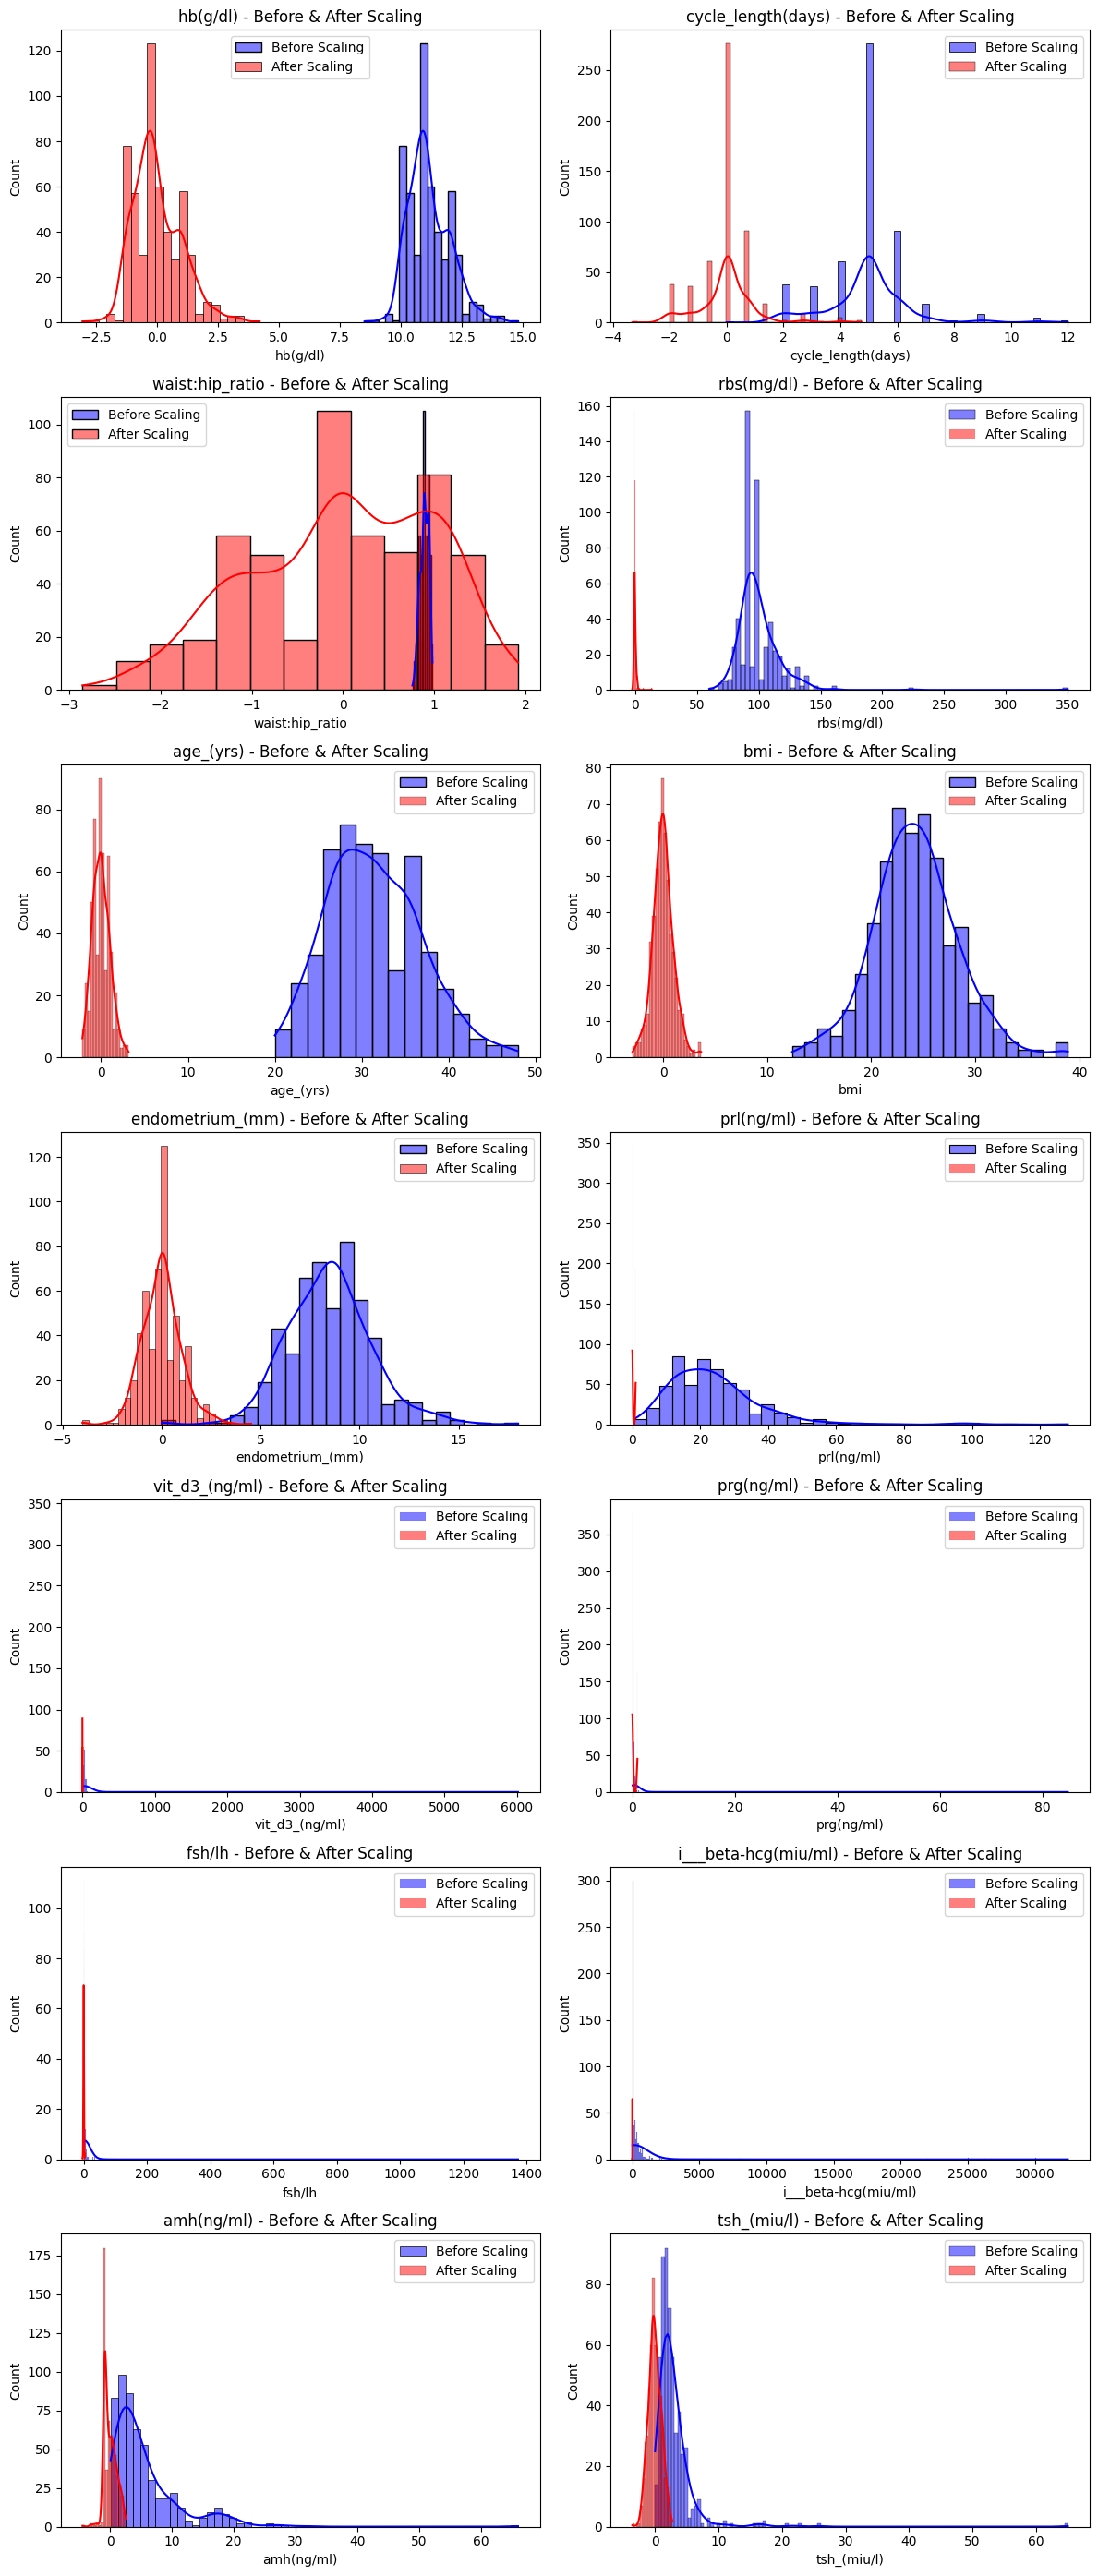

In [36]:
# Copy dataset
dataset_copy = dataset.copy()

# Define the columns to be scaled
scaled_columns = numerical_columns + numerical_columns_reduced + skewed_columns

# Apply the transformation
transformed_data = preprocessor.fit_transform(dataset_copy)

# Generate column names, including passthrough columns
transformed_column_names = (
    scaled_columns + 
    yesno_columns_reduced + 
    ['mean_arterial_pressure', 'total_follicle_number', 'average_follicle_size'] + 
    [col for col in dataset_copy.columns if col not in scaled_columns + yesno_columns_reduced + 
     ['bp__systolic_(mmhg)', 'bp__diastolic_(mmhg)', 'follicle_no._(l)', 'follicle_no._(r)', 
      'avg._f_size_(l)_(mm)', 'avg._f_size_(r)_(mm)']]
)

# Convert transformed data into a DataFrame
transformed_df = pd.DataFrame(transformed_data, columns=transformed_column_names)

# Define the number of rows and columns for the grid
num_columns = 2  # Number of plots per row
num_rows = int(np.ceil(len(scaled_columns) / num_columns))  # Number of rows needed

# Create subplots
fig, axes = plt.subplots(num_rows, num_columns, figsize=(12, 4 * num_rows))
axes = axes.flatten()  # Flatten in case of a single row

# Loop through each scaled column and plot before/after scaling
for i, column in enumerate(scaled_columns):
    sns.histplot(dataset_copy[column], kde=True, color='blue', label='Before Scaling', ax=axes[i])
    sns.histplot(transformed_df[column], kde=True, color='red', label='After Scaling', ax=axes[i])
    axes[i].legend()
    axes[i].set_title(f'{column} - Before & After Scaling')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()

Let's check that our preprocessing also contributed to reducing the value of the VIF in our features.

In [ ]:
def calculate_vif(dataset):
    vif = pd.DataFrame()
    vif["feature"] = dataset.columns
    vif["VIF"] = [variance_inflation_factor(dataset.values, i) for i in range(dataset.shape[1])]
    return(vif)


dataset_copy_2 = dataset.copy()
transformed_data_2 = preprocessor.fit_transform(dataset_copy_2)
transformed_dataset_2 = pd.DataFrame(transformed_data_2, columns=transformed_column_names)

features_vif = transformed_dataset_2.iloc[:,:-1]
calculate_vif(features_vif)

## Model selection

In this case we are only looking for a base model to check data sanity and integrity. Let's proceed.

In [37]:
starting_pipeline = IMBPipeline([
    ('trans', preprocessor),
    ('sampler', 'passthrough'),
    ('dim_reduction', 'passthrough'),
    ('classifier', LogisticRegression())
])

Let's fit the model and check its overall accuracy.

In [38]:
starting_pipeline.fit(X_train, y_train)
predictions = starting_pipeline.predict(X_test)

accuracy = accuracy_score(y_test, predictions)
print("Model Accuracy:", accuracy)

Model Accuracy: 0.8623853211009175


Now that the Pipeline setup and predictions have been successfully completed, we can also visualize it in order to grasp it better.

In [39]:
set_config(display="diagram")
starting_pipeline

Pipeline(steps=[('trans',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['hb(g/dl)',
                                                   'cycle_length(days)',
                                                   'waist:hip_ratio',
                                                   'rbs(mg/dl)']),
                                                 ('num_red',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age_(yrs)', 'bmi',
                                                   'endometrium_(mm)']),
                                                 ('yn',
                                                  Pipeline(steps=[('i...
                                                                 systolic_col='bp__systolic_(mmhg)'),
                                                  ['bp__systolic_(mmhg)',
                                                   'bp__diastolic_(mmhg)']),
                                                 ('follicle_number',
                                                  FollicleNumberTransformer(),
                                                  ['follicle_no._(l)',
                                                   'follicle_no._(r)']),
                                                 ('average_size',
                                                  AverageSizeTransformer(),
                                                  ['avg._f_size_(l)_(mm)',
                                                   'avg._f_size_(r)_(mm)'])])),
                ('sampler', 'passthrough'), ('dim_reduction', 'passthrough'),
                ('classifier', LogisticRegression())])

After we've seen the Pipeline, let's visualize the predictions.

In [40]:
print('Predictions:', predictions)

Predictions: [0 1 0 0 0 0 1 1 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 1 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 1 0 1 1 1 0 1 0 0 0 0 0 0 0 0
 0 1 1 1 1 0 1 0 1 1 1 1 0 1 0 0 1 1 0 0 0 1 1 0 1 1 0 1 0 0 0 0 0 0 1]


All the elements seem to be correctly defined, it's time to define the configurations of the hyperparameters we use in the hyperparameter optimization phase of the model selection.

### Hyperparameter Tuning

It's time to define which parameters the final model will have. In this phase, we define different dictionaries: one for sampling, one for dimensionality reduction and one for classifiers and use Carthesian product and cross-validation to later evaluate which combination will have the best performance of all.

In [41]:
sampler_configs = [
    {'sampler': [None]},  # No resampling
    {
        'sampler': [RandomOverSampler()],
        'sampler__sampling_strategy': ['minority']
    },
    {
        'sampler': [RandomUnderSampler()],
        'sampler__sampling_strategy': ['majority']
    },
    {
        'sampler' : [SMOTE()]
    }
]

dim_reduction_configs = [
    {'dim_reduction': [None]},  # No dimensionality reduction
    {
        'dim_reduction': [PCA(random_state=0)],
        'dim_reduction__n_components': [0.1, 0.5, 0.9]
    },
    {
        'dim_reduction': [SequentialFeatureSelector(estimator=Perceptron(), cv = None, scoring = 'f1')],
        'dim_reduction__estimator': [Perceptron(), LogisticRegression()],
        'dim_reduction__k_features' : [5,7,10]  
    },
    {
        'dim_reduction': [LDA()]
    }
]

I will compare the performance of 3 different ML algorithms to then evaluate which performs better and with which parameters.

In [42]:
classifier_configs = [
    # L1-regularization
    {
        'classifier': [LogisticRegression(random_state=0)],
        'classifier__C': np.logspace(-2, 2, 5),
        'classifier__penalty': ['l1'],
        'classifier__solver': ['saga', 'liblinear']
    },
    # L2-regularization
    {
        'classifier': [LogisticRegression(random_state=0)],
        'classifier__C': np.logspace(-2, 2, 5),
        'classifier__penalty': ['l2'],
        'classifier__solver': ['lbfgs']
    },
    {
        'classifier': [Perceptron()],
        'classifier__max_iter': [1,5,15,50],
        'classifier__eta0' : loguniform(0.001,100)
    },
    {
        'classifier': [KNeighborsClassifier()],
        'classifier__n_neighbors': [3, 5, 7]
    }
]

Generate all possible combinations using Carthesian product.

In [43]:
pipeline_configs = [dict(itertools.chain(*(e.items() 
for e in configuration))) 
for configuration in 
itertools.product(sampler_configs,dim_reduction_configs,classifier_configs)]

f'Number of all possible configurations: {len(pipeline_configs)}'

'Number of all possible configurations: 64'

Integrate into a Pipeline:

In [44]:
param_distribution = pipeline_configs

random_search = RandomizedSearchCV(
    starting_pipeline,
    param_distribution,
    scoring='f1',
    n_jobs=-1,
    n_iter=len(pipeline_configs) * 5,
    error_score='raise',
    verbose=1,
    random_state=42,
) # cv = 3 by default

Check which are the best models using cross validation.

In [45]:
scores = cross_validate(
    random_search,  
    X_train,
    y_train,
    scoring='f1', 
    cv=4,
    return_estimator=True,
    verbose=3,  
    n_jobs=-1,  
    error_score='raise'
) 

Fitting 5 folds for each of 320 candidates, totalling 1600 fits
[CV] END ......................................., score=0.800 total time= 4.8min
Fitting 5 folds for each of 320 candidates, totalling 1600 fits
[CV] END ......................................., score=0.870 total time= 4.7min
Fitting 5 folds for each of 320 candidates, totalling 1600 fits
[CV] END ......................................., score=0.711 total time= 4.6min
Fitting 5 folds for each of 320 candidates, totalling 1600 fits
[CV] END ......................................., score=0.806 total time= 4.5min


Now we can get an overview of the performance of the best models

In [46]:
# Iterate over all candidates and display their details with associated scores
for idx, estimator in enumerate(scores['estimator']):
    best_params = estimator.best_estimator_.get_params()
    print(f"Candidate {idx + 1}:")
    print(f"  Sampler:         {best_params['sampler']}")
    print(f"  Dim Reduction:   {best_params['dim_reduction']}")
    print(f"  Classifier:      {best_params['classifier']}")
    print(f"  Classifier Params: {best_params['classifier'].get_params()}")
    print(f"  Test Score:      {scores['test_score'][idx]:.4f}")
    print("-" * 40)

Candidate 1:
  Sampler:         None
  Dim Reduction:   LinearDiscriminantAnalysis()
  Classifier:      LogisticRegression(random_state=0)
  Classifier Params: {'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'deprecated', 'n_jobs': None, 'penalty': 'l2', 'random_state': 0, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
  Test Score:      0.8000
----------------------------------------
Candidate 2:
  Sampler:         None
  Dim Reduction:   SequentialFeatureSelector(cv=None, estimator=Perceptron(), k_features=(10, 10),
                          scoring='f1')
  Classifier:      LogisticRegression(C=0.09999999999999999, random_state=0)
  Classifier Params: {'C': 0.09999999999999999, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'deprecated', 'n_jobs': None, 'penalty': 'l2', 'random_sta

Implement the estimator with the best score.

In [47]:
for estimator in scores['estimator']:
    pred_train = estimator.best_estimator_.fit(X_train, y_train)
    pred_train = estimator.best_estimator_.predict(X_train)
    pred_test = estimator.best_estimator_.predict(X_test)
    f1_train = f1_score(y_train, pred_train)
    f1_test = f1_score(y_test, pred_test)
    print(f'F1 on training set:{f1_train}, F1 on test set:{f1_test}')


F1 on training set:0.8296296296296296, F1 on test set:0.7837837837837838
F1 on training set:0.835820895522388, F1 on test set:0.8059701492537313
F1 on training set:0.802675585284281, F1 on test set:0.7894736842105263
F1 on training set:0.8024691358024691, F1 on test set:0.7142857142857143


In the next section, we will try to refine the performance of our best candidate (Estimator 2) and evaluate possible issues of the model in terms of bias/variance trade-off and overfitting.

Estimator 2 is the best because F1 score is high enough both in Train and Test samples, and there isn't a big difference between them, suggesting there is little to no overfitting.

### Refinement of the Selected model

Based on Estimator 2, the pipeline should include:

- Sampler: RandomOverSampler(sampling_strategy='minority')

- Dimensionality Reduction: LDA()

- Classifier: LogisticRegression(penalty='l1', solver='saga')

In [86]:
selected_pipeline = IMBPipeline([
    ('trans', preprocessor),
    ('sampler', SMOTE()),
    ('dim_reduction', SequentialFeatureSelector(estimator=LogisticRegression(random_state=0))),
    ('classifier', LogisticRegression(random_state=0, penalty='l1', solver='liblinear'))
])

Let's further refine the selected pipeline with hyperparameter tuning for Logistic Regression.

In [87]:
params = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'classifier__max_iter': [100, 300, 500],
    'dim_reduction__scoring': ['f1', 'roc_auc'],
    'dim_reduction__cv': [None, 5]
}

# Set up cross-validation
cv = RepeatedStratifiedKFold(n_splits=4, n_repeats=3)

# Randomized search - inner loop
rs_best = RandomizedSearchCV(
    estimator=selected_pipeline,
    param_distributions=params,
    cv=cv,
    n_iter=30,
    scoring='f1',
    random_state=0,
    verbose=1,
    n_jobs=-1
)

In [88]:
# Fit the updated pipeline
rs_best.fit(X_train, y_train)

Fitting 12 folds for each of 30 candidates, totalling 360 fits


RandomizedSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=4, random_state=None),
                   estimator=Pipeline(steps=[('trans',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('num',
                                                                               Pipeline(steps=[('scaler',
                                                                                                StandardScaler())]),
                                                                               ['hb(g/dl)',
                                                                                'cycle_length(days)',
                                                                                'waist:hip_ratio',
                                                                                'rbs(mg/dl)']),
                                                                              ('num_red',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(...
                                              SequentialFeatureSelector(estimator=LogisticRegression(random_state=0),
                                                                        scoring='accuracy')),
                                             ('classifier',
                                              LogisticRegression(penalty='l1',
                                                                 random_state=0,
                                                                 solver='liblinear'))]),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'classifier__C': [0.001, 0.01, 0.1, 1,
                                                          10, 100, 1000],
                                        'classifier__max_iter': [100, 300, 500],
                                        'dim_reduction__cv': [None, 5],
                                        'dim_reduction__scoring': ['f1',
                                                                   'roc_auc']},
                   random_state=0, scoring='f1', verbose=1)

In [89]:
print("Best Parameters:", rs_best.best_params_)

Best Parameters: {'dim_reduction__scoring': 'f1', 'dim_reduction__cv': 5, 'classifier__max_iter': 100, 'classifier__C': 1000}


Check F1 scores to detect early signs of overfitting or underfitting. It's very likely that if they're both low, there might be underfitting, while if the training score is much higher than the test score, there might be overfitting.

In [90]:
f1_score(y_test, rs_best.best_estimator_.predict(X_test))

0.7272727272727273

Check also using a confusion matrix.

In [91]:
y_train_pred = best_model.predict(X_train)

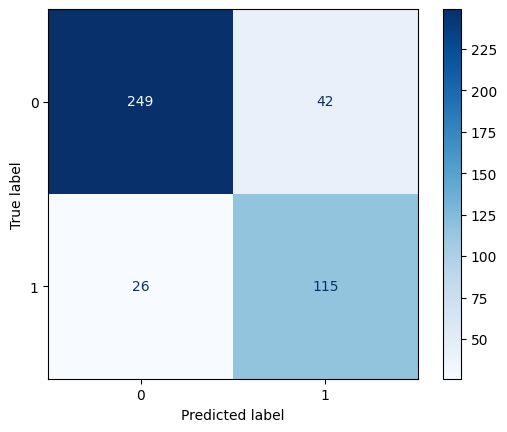

array([[249,  42],
       [ 26, 115]])

In [92]:
conf_matrix = confusion_matrix(y_train, y_train_pred)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, cmap=plt.cm.Blues)
plt.show()
conf_matrix

### Learning curve

(0.6, 1.03)

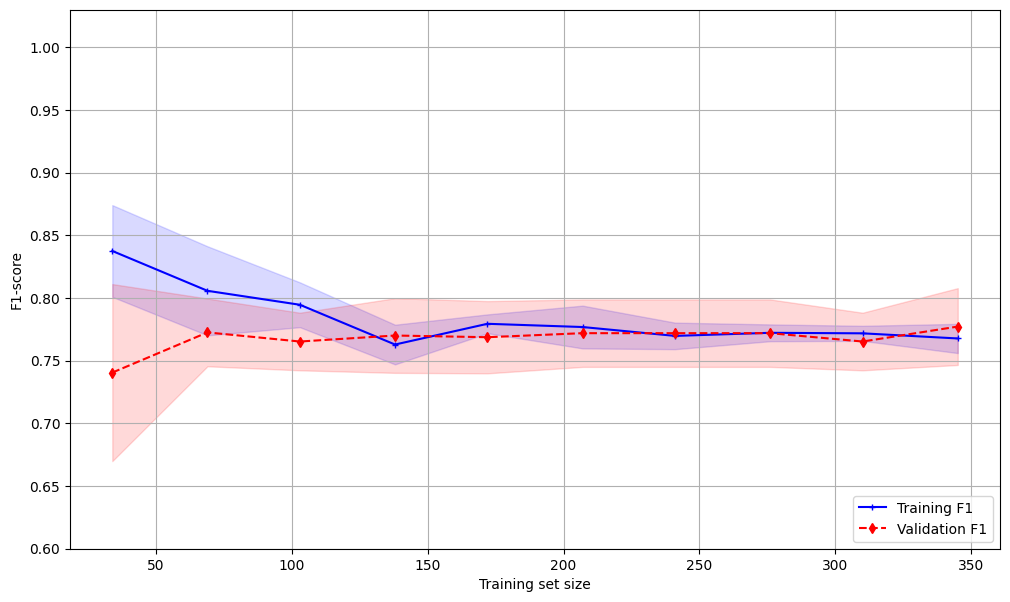

In [93]:
train_sizes, train_scores, test_scores = learning_curve(
    selected_pipeline,
    X_train,
    y_train,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    train_sizes=[0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    shuffle=False
)

train_mean = train_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
test_mean = test_scores.mean(axis=1)
test_std = test_scores.std(axis=1)

fig=plt.figure(figsize=(12,7))
ax = fig.add_subplot()

ax.plot(train_sizes, train_mean,
         color='blue', marker='+',
         markersize=5, label='Training F1')

ax.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

ax.plot(train_sizes, test_mean,
         color='red', linestyle='--',
         marker='d', markersize=5,
         label='Validation F1')

ax.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='red')

ax.grid()
ax.set_xlabel('Training set size')
ax.set_ylabel('F1-score')
ax.legend(loc='lower right')
ax.set_ylim([0.60, 1.03])

(0.05, 100)

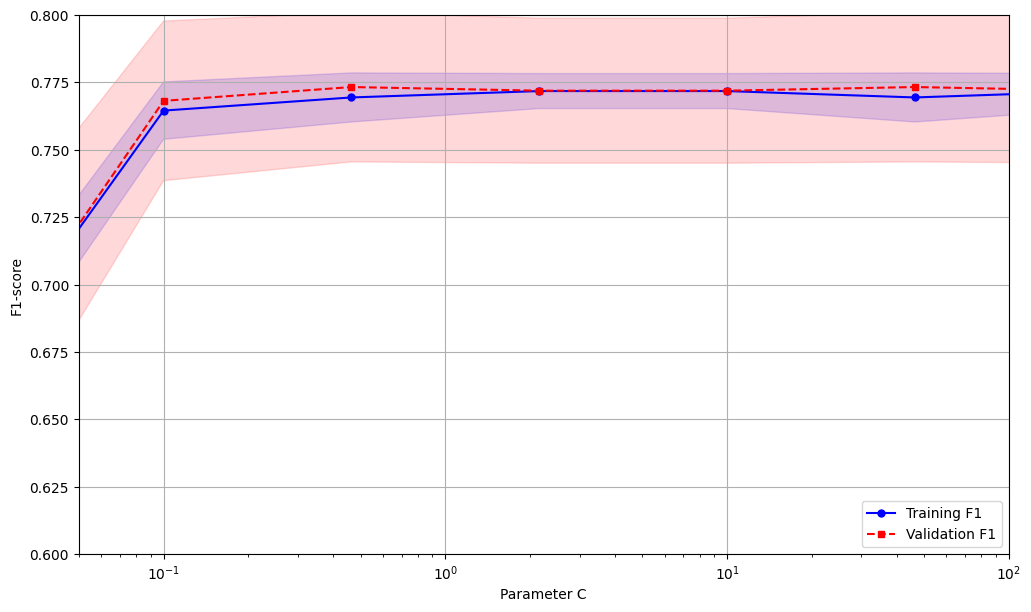

In [94]:
param_range = np.logspace(-3, 3, 10)
train_scores, test_scores = validation_curve(
   selected_pipeline,
   X_train, 
   y_train,
   param_name='classifier__C',
   param_range=param_range,
   cv=5,
   n_jobs=-1,
   scoring='f1'
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

fig=plt.figure(figsize=(12,7))
ax = fig.add_subplot()
ax.plot(param_range, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training F1')

ax.fill_between(param_range,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

ax.plot(param_range, test_mean,
         color='red', linestyle='--',
         marker='s', markersize=5,
         label='Validation F1')

ax.fill_between(param_range,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='red')

ax.grid()
ax.set_xlabel('Parameter C')
ax.set_ylabel('F1-score')
ax.legend(loc='lower right')
ax.set_ylim([0.6, 0.8])
ax.set_xscale('log')
ax.set_xlim([0.05,100])

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=704ca8a1-89c5-4e60-86da-918712a50525' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>